In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm 
from sklearn.datasets import make_friedman2, make_friedman1, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
sns.set_style("whitegrid", {'axes.grid' : False})

### Simulating Friendman dataset

**About the dataset**

Inputs X are independent features uniformly distributed on the interval [0, 1]. The output y is created according to the formula:   
`y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).`

Out of the n_features features, only 5 are actually used to compute y. The remaining features are independent of y.

In [4]:
# simulating 10,000 data points with 2 useless and 5 uniformly distributed features

X, y = make_friedman1(n_samples=10000, n_features=7, noise=0.0, random_state=11)

In [5]:
min(y), max(y) 

(0.3545368892371061, 28.516918961287963)

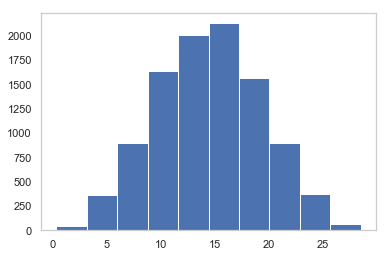

In [6]:
# distribution of target variable
h = plt.hist(y)

In [7]:
# train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
### Plotting helper functions

def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for validation set for given model 
    """
    ax = sns.distplot(y_valid - model.predict(X_valid), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Residual histogram', size=15)

def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from validation set
    """
    ax = sns.scatterplot(x=model.predict(X_valid), y = y_valid)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)    

### Random Forest

In [9]:
# basic random forest regressor with mse as criterion to measure the quality of split

rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=33)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=33, verbose=0, warm_start=False)

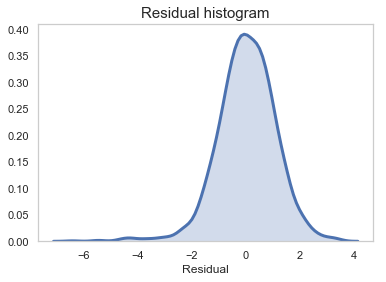

In [10]:
# distribution of residual
plot_residual_distribution(rf)

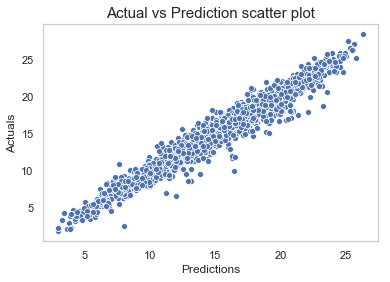

In [11]:
plot_scatter_pred_actual(rf)

In [12]:
print(f"MSE is {mean_squared_error(y_valid, rf.predict(X_valid))}")

MSE is 1.1575421924161375


### Default LightGBM

#### Dafault out of the box

In [13]:
# make new model on new value
gbm = lightgbm.LGBMRegressor(random_state=33)

In [14]:
gbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=33,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [15]:
gbm.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=33,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [16]:
print(f"MSE is {mean_squared_error(y_valid, gbm.predict(X_valid))}")

MSE is 0.24036310399447477


In [17]:
gbm.best_score_  # since there is no eval_set given

defaultdict(dict, {})

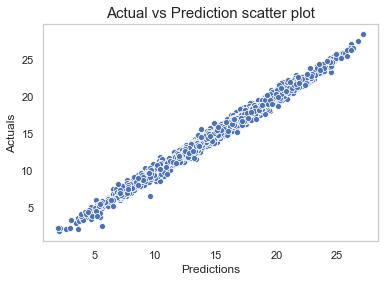

In [18]:
plot_scatter_pred_actual(gbm)

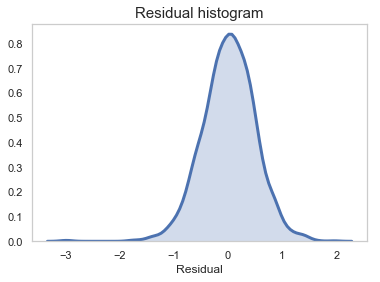

In [19]:
plot_residual_distribution(gbm)

We see that GBM has performed a better than random forest model for our validation MSE score

#### Passing in `eval_set`

In [20]:
# make new model on new value
# 'regression' is actually also the default objective for LGBMRegressor

gbm1 = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
#                               early_stopping_rounds = 10,
#                               n_estimators=10000
                             )

In [21]:
gbm1.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',  # also the default
    verbose=False,
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=33,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [22]:
print('MSE/L2:', mean_squared_error(y_valid, gbm1.predict(X_valid)))

MSE/L2: 0.24036310399447477


In [23]:
gbm1.best_score_

defaultdict(dict, {'valid_0': {'l2': 0.240363089242883}})

In [24]:
gbm1.booster_.current_iteration()

100

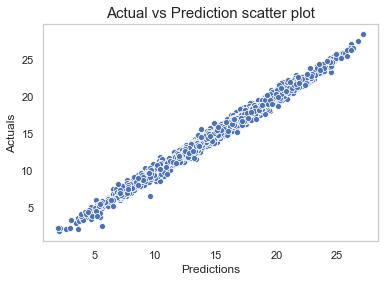

In [25]:
plot_scatter_pred_actual(gbm1)

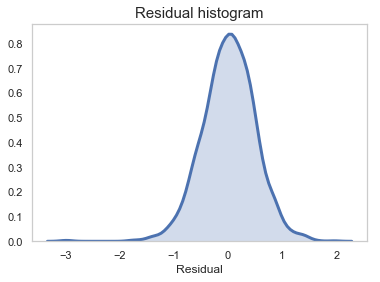

In [26]:
plot_residual_distribution(gbm1)

It is basically similar to the default model we fitted in the previous section but we did not use `eval_set` in that section. Because we are specifically mentioning `eval_set` in this case, we can leverage `early_stopping_rounds` and run for more boosting iterations which improves our model performance aand saves best score based on the give `metrics and eval_score`. This improvement in shown in the next section

#### Using `early_stopping_rounds` with eval_set

In [27]:
# make new model on new value
# 'regression' is actually also the default objective for LGBMRegressor

gbm12 = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

In [28]:
gbm12.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',  # also the default
    verbose=False,
)

/Users/groverpr/.pyenv/versions/3.7.0/envs/cortex_3_7/lib/python3.7/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping_rounds=10, learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=33, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [29]:
print('MSE/L2:', mean_squared_error(y_valid, gbm12.predict(X_valid)))

MSE/L2: 0.14149260034671074


In [30]:
gbm12.best_score_

defaultdict(dict, {'valid_0': {'l2': 0.14149259440723364}})

In [31]:
gbm12.booster_.current_iteration()

780

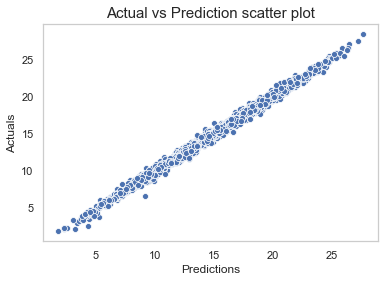

In [32]:
plot_scatter_pred_actual(gbm12)

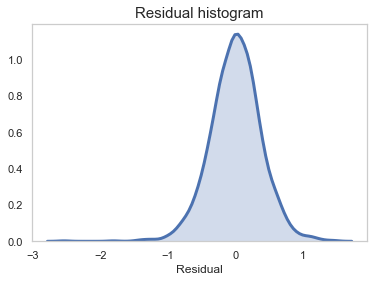

In [33]:
plot_residual_distribution(gbm12)

We see an improvement in score as the model is able to run for more boosting iterations 

### Assymetric Custom Loss 

There are 2 parameters that we might be interested in which define the traininig process in gradient boosted based tree based models. In context of LightGBM, we 

In LightGBM training API: 
* fobj: Customized objective function
* feval: Customized evaluation function. basically a way to use custom metric for cv. used in addition to metric 
* metric: a function to be monitored while doing cross validation. (select hyperparameters that minimize or maximuze this). can be plural

In sklearn wrapper around LightGBM API:
* objective: default parameter in model()
* eval_metric in model.fit()

I am going to use sklearn wrapper to set the objective and evaluation metric, but these are essentially the same

Let's say that we don't want our model to overpredict, but we are fine with underpredictions.    

We can make a custom loss which gives 5 times more penalty when the true targets
are less than predictions as compared to when true targets are more

In [34]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*5.0*residual, -2*residual)
    hess = np.where(residual<0, 2*5.0, 2.0)
    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*5.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

#### Exploring our custom loss function with some plots

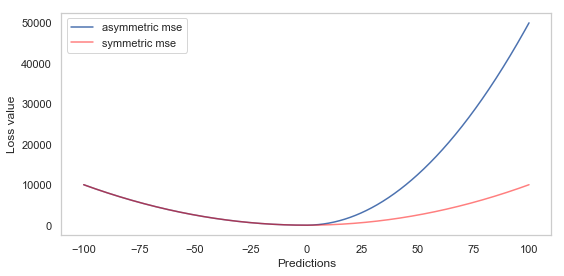

In [35]:
# let's see how our custom loss function looks with respect to different prediction values

y_true = np.repeat(0,1000)
y_pred = np.linspace(-100,100,1000)
residual = (y_true - y_pred).astype("float")

custom_loss = np.where(residual < 0, (residual**2)*5.0, residual**2) 

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.lineplot(y_pred, custom_loss, alpha=1, label="asymmetric mse")
sns.lineplot(y_pred, residual**2, alpha = 0.5, label = "symmetric mse", color="red")
ax.set_xlabel("Predictions")
ax.set_ylabel("Loss value")

fig.tight_layout()

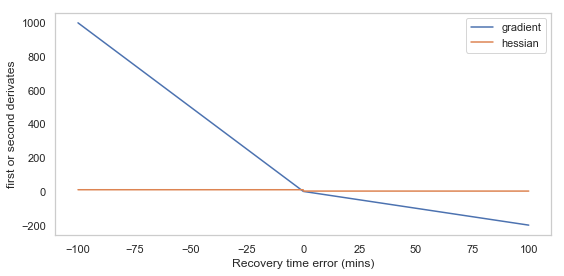

In [36]:
grad, hess = custom_asymmetric_objective(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

# ax.plot(y_hat, errors)
ax.plot(residual, grad)
ax.plot(residual, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Recovery time error (mins)')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

The behaviour of gradient of custom loss is as per our expecation. The slope has a little higher value when the residual is negative as compared to when it is positive

#### Fitting LightGBM using custom loss

In [37]:
# make new model on new value
gbm2 = lightgbm.LGBMRegressor(random_state=33,
#                               early_stopping_rounds = 10,
#                               n_estimators=10000
                             )

In [38]:
gbm2.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metrics=['mse', 'mae'],
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31,
       objective=<function custom_asymmetric_objective at 0x112d83400>,
       random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
gbm2.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metrics=['mse', 'mae'],
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31,
       objective=<function custom_asymmetric_objective at 0x112d83400>,
       random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [40]:
print('MSE/L2:', mean_squared_error(y_valid, gbm2.predict(X_valid)))

MSE/L2: 0.2939577221714613


In [41]:
gbm2.best_score_

defaultdict(dict,
            {'valid_0': {'l1': 0.42046937299397386,
              'l2': 0.29395770784570213,
              'custom_asymmetric_eval': 0.5771733967894707}})

This is because, the `best_score_` now represents asymmetric custom loss that we have defined and passed in evaluation metic

In [42]:
_,loss_gbm2,_ = custom_asymmetric_eval(y_valid, gbm2.predict(X_valid))
print('Custom asymmetric loss:', loss_gbm2)

Custom asymmetric loss: 0.5771733967894707


In [43]:
_,loss_gbm1,_ = custom_asymmetric_eval(y_valid, gbm1.predict(X_valid))
print('Custom asymmetric mse when we used regression objective:', loss_gbm1)

Custom asymmetric mse when we used regression objective: 0.7159129370145981


In [44]:
gbm2.booster_.current_iteration()

100

This matches with `gbm2.best_score_`. Let's also check the score on asymmetric custom loss for previous `gbm1` model

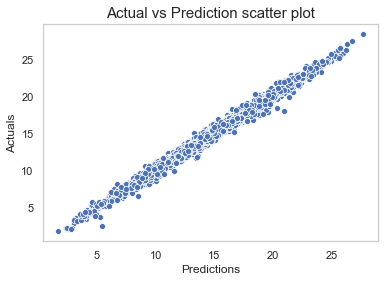

In [45]:
plot_scatter_pred_actual(gbm2)

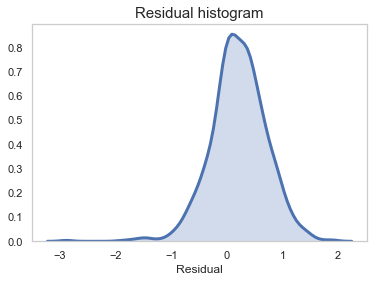

In [46]:
plot_residual_distribution(gbm2)

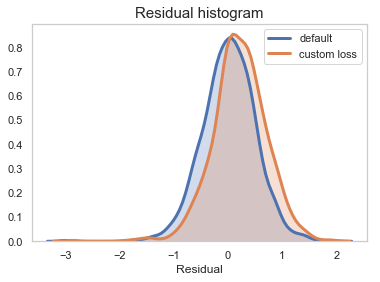

In [47]:
ax = sns.distplot(y_valid - gbm1.predict(X_valid), hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual", label = "default")
ax = sns.distplot(y_valid - gbm2.predict(X_valid), hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual", label = "custom loss")
title = ax.set_title('Residual histogram', size=15)

#### LightGBM using custom loss and early boosting rounds 

In [53]:
# make new model on new value
gbm22 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

In [54]:
gbm22.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping_rounds=10, learning_rate=0.1, max_depth=-1,
       metrics=['mse', 'mae'], min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31,
       objective=<function custom_asymmetric_objective at 0x112d83400>,
       random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
gbm22.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

/Users/groverpr/.pyenv/versions/3.7.0/envs/cortex_3_7/lib/python3.7/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping_rounds=10, learning_rate=0.1, max_depth=-1,
       metrics=['mse', 'mae'], min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31,
       objective=<function custom_asymmetric_objective at 0x112d83400>,
       random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Reporting scores for different models

In [59]:
# asymmetric mse scores
_,loss_rf,_ = custom_asymmetric_eval(y_valid, rf.predict(X_valid))
_,loss_gbm1,_ = custom_asymmetric_eval(y_valid, gbm1.predict(X_valid))
_,loss_gbm12,_ = custom_asymmetric_eval(y_valid, gbm12.predict(X_valid))
_,loss_gbm2,_ = custom_asymmetric_eval(y_valid, gbm2.predict(X_valid))
_,loss_gbm22,_ = custom_asymmetric_eval(y_valid, gbm22.predict(X_valid))

In [70]:
score_dict = {'Random Forest default':
              {'asymmetric custom mse': loss_rf,
               'symmetric mse': mean_squared_error(y_valid, rf.predict(X_valid)),
               'symmetric mae': mean_absolute_error(y_valid, rf.predict(X_valid)), 
               'number of boosts' : '-'},
              
              'LightGBM default' : 
              {'asymmetric custom mse': loss_gbm1,
               'symmetric mse': mean_squared_error(y_valid, gbm1.predict(X_valid)), 
               'symmetric mae': mean_absolute_error(y_valid, gbm1.predict(X_valid)), 
               'number of boosts' : gbm1.booster_.current_iteration()},
              
              'LightGBM with custom_loss' : 
              {'asymmetric custom mse': loss_gbm2,
               'symmetric mse': mean_squared_error(y_valid, gbm2.predict(X_valid)),
               'symmetric mae': mean_absolute_error(y_valid, gbm2.predict(X_valid)),
               'number of boosts' : gbm2.booster_.current_iteration()},
              
             'LightGBM with more boosts via early_stopping': 
              {'asymmetric custom mse': loss_gbm12,
               'symmetric mse': mean_squared_error(y_valid, gbm12.predict(X_valid)),
               'symmetric mae': mean_absolute_error(y_valid, gbm12.predict(X_valid)),
               'number of boosts' : gbm12.booster_.current_iteration()},

             'LightGBM with more boosts via early_stopping and custom eval': 
              {'asymmetric custom mse': loss_gbm22,
               'symmetric mse': mean_squared_error(y_valid, gbm22.predict(X_valid)),
               'symmetric mae': mean_absolute_error(y_valid, gbm22.predict(X_valid)),
               'number of boosts' : gbm22.booster_.current_iteration()}}

In [71]:
pd.DataFrame(score_dict).T

,asymmetric custom mse,number of boosts,symmetric mae,symmetric mse
Random Forest default,3.58917,-,0.817336,1.15754
LightGBM default,0.715913,100,0.380857,0.240363
LightGBM with custom_loss,0.577173,100,0.420469,0.293958
LightGBM with more boosts via early_stopping,0.424042,780,0.288101,0.141493
LightGBM with more boosts via early_stopping and custom eval,0.446212,378,0.335074,0.187603


### End